In [1]:
import os
import re
import datetime as dt
from multiprocessing import Pool


import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import unidecode
from word2number import w2n

In [2]:
# determine if running on mac laptop or linux rig
def load_file():
    def open_training_data(file_location):
        return  pd.read_csv(file_location + "training.1600000.processed.noemoticon.csv", 
                 names=['sentiment','tweet_id','timestamp','useless','username', 'tweet'],
                 encoding='ISO-8859-1')
    if os.uname().sysname == 'Darwin':
        print("loading mac file location")
        return open_training_data("sentiment140dataset/")
    elif os.uname().sysname == 'Linux':
        print("loading linux file location")
        return open_training_data("/mnt/c/Users/steve/Documents/ML_Files/DS_4900/trainingandtestdata/")
    else:
        raise RuntimeException(f"System name not found, found {os.uname().sysname}")

In [3]:
raw_df = load_file()
raw_df.head()

loading linux file location


,sentiment,tweet_id,timestamp,useless,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Drop useless columns and format timestamp column

In [4]:
clean_df = raw_df.drop(['sentiment', 'useless', 'username'], axis=1)
form = "%a %b %d %H:%M:%S PDT %Y"
clean_df['timestamp'] = pd.to_datetime(clean_df['timestamp'], format=form)
clean_df['date'] = clean_df['timestamp'].dt.floor('d')

Create Timeline of Tweets per day

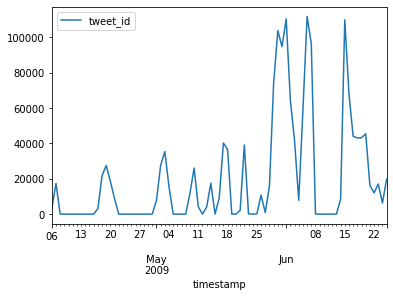

In [5]:
date_counts = clean_df.resample('D', on='timestamp').count()
date_counts.plot(kind='line',y='tweet_id')
plt.show()

# Text PreProcessing

First we need a wordcloud function so we easily visualize our most popular words

In [6]:
def make_wordcloud(tweet_col):
    # Join the different processed titles together.
    long_string = ','.join(list(tweet_col.values))
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

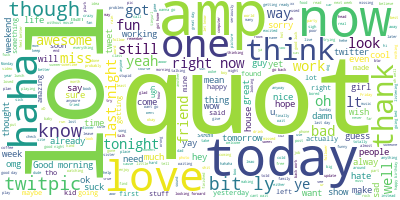

In [7]:
make_wordcloud(clean_df['tweet'])

Next setup some objects to help prepare the text

In [8]:
# using the pycontractions package was giving weird errors on some cases, we only need the functionality that replaces the 
# contraction with the extended version as it doesn't matter if there are grammar issues since most of these are small stopwords
# anyways
cont = {
    re.compile(r"\bcan'?t\b", re.I | re.U): "cannot",
    re.compile(r"\bcan'?t'?ve\b", re.I | re.U): "cannot have",
    re.compile(r"\b'?cause\b", re.I | re.U): "because",
    re.compile(r"\bcould'?ve\b", re.I | re.U): "could have",
    re.compile(r"\bcouldn'?t\b", re.I | re.U): "could not",
    re.compile(r"\bcouldn'?t'?ve\b", re.I | re.U): "could not have",
    re.compile(r"\bdidn'?t\b", re.I | re.U): "did not",
    re.compile(r"\bdoesn'?t\b", re.I | re.U): "does not",
    re.compile(r"\bdon'?t\b", re.I | re.U): "do not",
    re.compile(r"\bdoin'?\b", re.I | re.U): "doing",
    re.compile(r"\bdunno\b", re.I | re.U): "do not know",
    re.compile(r"\bgimme'?\b", re.I | re.U): "give me",
    re.compile(r"\bgoin'?\b", re.I | re.U): "going",
    re.compile(r"\bgonna'?\b", re.I | re.U): "going to",
    re.compile(r"\bhadn'?t\b", re.I | re.U): "had not",
    re.compile(r"\bhadn'?t'?ve\b", re.I | re.U): "had not have",
    re.compile(r"\bhasn'?t\b", re.I | re.U): "has not",
    re.compile(r"\bhaven'?t\b", re.I | re.U): "have not",
    re.compile(r"\bhe'?d'?ve\b", re.I | re.U): "he would have",
    re.compile(r"\bhow'?d\b", re.I | re.U): "how did",
    re.compile(r"\bhow'?d'?y\b", re.I | re.U): "how do you",
    re.compile(r"\bhow'?ll\b", re.I | re.U): "how will",
    re.compile(r"\bI'?d'?ve\b", re.I | re.U): "I would have",
    re.compile(r"\bI'?m\b", re.I | re.U): "I am",
    re.compile(r"\bI'?ve\b", re.I | re.U): "I have",
    re.compile(r"\bisn'?t\b", re.I | re.U): "is not",
    re.compile(r"\bit'?d'?ve\b", re.I | re.U): "it would have",
    re.compile(r"\bkinda\b", re.I | re.U): "kind of",
    re.compile(r"\blet'?s\b", re.I | re.U): "let us",
    re.compile(r"\bma'?am\b", re.I | re.U): "madam",
    re.compile(r"\bmayn'?t\b", re.I | re.U): "may not",
    re.compile(r"\bmight'?ve\b", re.I | re.U): "might have",
    re.compile(r"\bmightn'?t\b", re.I | re.U): "might not",
    re.compile(r"\bmightn'?t'?ve\b", re.I | re.U): "might not have",
    re.compile(r"\bmust'?ve\b", re.I | re.U): "must have",
    re.compile(r"\bmustn'?t\b", re.I | re.U): "must not",
    re.compile(r"\bmustn'?t'?ve\b", re.I | re.U): "must not have",
    re.compile(r"\bnothin'?\b", re.I | re.U): "nothing",
    re.compile(r"\bneedn'?t\b", re.I | re.U): "need not",
    re.compile(r"\bneedn'?t'?ve\b", re.I | re.U): "need not have",
    re.compile(r"\bo'?clock\b", re.I | re.U): "of the clock",
    re.compile(r"\boughta\b", re.I | re.U): "ought to",
    re.compile(r"\boughtn'?t\b", re.I | re.U): "ought not",
    re.compile(r"\boughtn'?t'?ve\b", re.I | re.U): "ought not have",
    re.compile(r"\bshan'?t\b", re.I | re.U): "shall not",
    re.compile(r"\bsha'?n'?t\b", re.I | re.U): "shall not",
    re.compile(r"\bshan'?t'?ve\b", re.I | re.U): "shall not have",
    re.compile(r"\bshe'?d'?ve\b", re.I | re.U): "she would have",
    re.compile(r"\bshould'?ve\b", re.I | re.U): "should have",
    re.compile(r"\bshouldn'?t\b", re.I | re.U): "should not",
    re.compile(r"\bshouldn'?t'?ve\b", re.I | re.U): "should not have",
    re.compile(r"\bso'?ve\b", re.I | re.U): "so have",
    re.compile(r"\bsomethin'?\b", re.I | re.U): "something",
    re.compile(r"\bthat'?d'?ve\b", re.I | re.U): "that would have",
    re.compile(r"\bthere'?d'?ve\b", re.I | re.U): "there would have",
    re.compile(r"\bthey'?d'?ve\b", re.I | re.U): "they would have",
    re.compile(r"\bthey'?re\b", re.I | re.U): "they are",
    re.compile(r"\bthey'?ve\b", re.I | re.U): "they have",
    re.compile(r"\b'?tis\b", re.I | re.U): "it is",
    re.compile(r"\bto'?ve\b", re.I | re.U): "to have",
    re.compile(r"\bu\b(?!\.)", re.I | re.U): "you",
    re.compile(r"\bwasn'?t\b", re.I | re.U): "was not",
    re.compile(r"\bwanna'?\b", re.I | re.U): "want to",
    re.compile(r"\bwe'?d'?ve\b", re.I | re.U): "we would have",
    re.compile(r"\bwe'll\b", re.I | re.U): "we will",
    re.compile(r"\bwe'?ll'?ve\b", re.I | re.U): "we will have",
    re.compile(r"\bwe're\b", re.I | re.U): "we are",
    re.compile(r"\bwe'?ve\b", re.I | re.U): "we have",
    re.compile(r"\bweren'?t\b", re.I | re.U): "were not",
    re.compile(r"\bwhat'?re\b", re.I | re.U): "what are",
    re.compile(r"\bwhat'?ve\b", re.I | re.U): "what have",
    re.compile(r"\bwhen'?ve\b", re.I | re.U): "when have",
    re.compile(r"\bwhere'?d\b", re.I | re.U): "where did",
    re.compile(r"\bwhere'?ve\b", re.I | re.U): "where have",
    re.compile(r"\bwho'?ve\b", re.I | re.U): "who have",
    re.compile(r"\bwhy'?ve\b", re.I | re.U): "why have",
    re.compile(r"\bwill'?ve\b", re.I | re.U): "will have",
    re.compile(r"\bwon'?t\b", re.I | re.U): "will not",
    re.compile(r"\bwon'?t'?ve\b", re.I | re.U): "will not have",
    re.compile(r"\bwould'?ve\b", re.I | re.U): "would have",
    re.compile(r"\bwouldn'?t\b", re.I | re.U): "would not",
    re.compile(r"\bwouldn'?t'?ve\b", re.I | re.U): "would not have",
    re.compile(r"\by'?all\b", re.I | re.U): "you all",
    re.compile(r"\by'?all'?d\b", re.I | re.U): "you all would",
    re.compile(r"\by'?all'?d'?ve\b", re.I | re.U): "you all would have",
    re.compile(r"\by'?all'?re\b", re.I | re.U): "you all are",
    re.compile(r"\by'?all'?ve\b", re.I | re.U): "you all have",
    re.compile(r"\byou'?d'?ve\b", re.I | re.U): "you would have",
    re.compile(r"\byou'?re\b", re.I | re.U): "you are",
    re.compile(r"\byou'?ve\b", re.I | re.U): "you have",
    re.compile(r"\bain'?t\b", re.I | re.U): "am not",
    re.compile(r"\baren'?t\b", re.I | re.U): "are not",
    re.compile(r"\bhe'?d\b", re.I | re.U): "he had", 
    re.compile(r"\bhe'll\b", re.I | re.U): "he shall",
    re.compile(r"\bhe'?ll'?ve\b", re.I | re.U): "he shall have",
    re.compile(r"\bhe'?s\b", re.I | re.U): "he has", 
    re.compile(r"\bhow'?s\b", re.I | re.U): "how has",
    re.compile(r"\bI'd\b", re.I | re.U): "I had", 
    re.compile(r"\bI'll\b", re.I | re.U): "I shall",
    re.compile(r"\bI'?ll'?ve\b", re.I | re.U): "I shall have",
    re.compile(r"\bit'?d\b", re.I | re.U): "it had", 
    re.compile(r"\bit'?ll\b", re.I | re.U): "it shall",
    re.compile(r"\bit'?ll'?ve\b", re.I | re.U): "it shall have",
    re.compile(r"\bit's\b", re.I | re.U): "it has", 
    re.compile(r"\bshe'?d\b", re.I | re.U): "she had",
    re.compile(r"\bshe'll\b", re.I | re.U):  "she will",
    re.compile(r"\bshe'?ll'?ve\b", re.I | re.U): "she will have",
    re.compile(r"\bshe'?s\b", re.I | re.U): "she is",
    re.compile(r"\bso'?s\b", re.I | re.U): "so as",
    re.compile(r"\bthat'?d\b", re.I | re.U): "that would",
    re.compile(r"\bthat'?s\b", re.I | re.U): "that has",
    re.compile(r"\bthere'?d\b", re.I | re.U): "there had",
    re.compile(r"\bthere'?s\b", re.I | re.U): "there has",
    re.compile(r"\bthey'?d\b", re.I | re.U): "they had",
    re.compile(r"\bthey'?ll\b", re.I | re.U): "they shall",
    re.compile(r"\bthey'?ll'?ve\b", re.I | re.U): "they shall have",
    re.compile(r"\bwe'd\b", re.I | re.U): "we had",
    re.compile(r"\bwhat'?ll\b", re.I | re.U): "what shall",
    re.compile(r"\bwhat'?ll'?ve\b", re.I | re.U): "what shall have",
    re.compile(r"\bwhat'?s\b", re.I | re.U): "what has",
    re.compile(r"\bwhen'?s\b", re.I | re.U): "when has",
    re.compile(r"\bwhere'?s\b", re.I | re.U): "where has",
    re.compile(r"\bwho'?ll\b", re.I | re.U): "who shall",
    re.compile(r"\bwho'?ll'?ve\b", re.I | re.U): "who shall have",
    re.compile(r"\bwho'?s\b", re.I | re.U): "who has",
    re.compile(r"\bwhy'?s\b", re.I | re.U): "why has",
    re.compile(r"\byou'?d\b", re.I | re.U): "you had",
    re.compile(r"\byou'?ll\b", re.I | re.U): "you shall",
    re.compile(r"\byou'?ll'?ve\b", re.I | re.U): "you shall have",
}

In [9]:
spcy = spacy.load('en_core_web_sm')

Now implement the text cleaning functions

In [10]:
def accent_toascii(tweet_col):
    return tweet_col.map(lambda x: unidecode.unidecode(x))

def expand_contractions(tweet_col):
    # some contractions were throwing errors on my linux machine but not on my mac, so prehandle them here
    def expand_one_tweet(tweet):
        for pattern, rep in cont.items():
            tweet = pattern.sub(rep, tweet)
        return tweet
    return tweet_col.map(lambda x: expand_one_tweet(x))

def expand_abbreviations(tweet_col):
    print("abbreviations not yet implemented")
    return tweet_col

def lowercase(tweet_col):
    return tweet_col.map(lambda x: x.lower())

def handle_numbers(tweet_col, convert=True, remove=True):
    def convert_number_words(word):
        try:
            return str(w2n.word_to_num(word))
        except ValueError as e:
            return word
    def remove_numbers(tweet):
        return re.sub('[0-9]', '', tweet)
    
    if convert and remove:
        return tweet_col.map(lambda x: remove_numbers(" ".join([convert_number_words(word) for word in x.split(" ")])))
    elif convert and not remove:
        return tweet_col.map(lambda x: " ".join([convert_number_words(word) for word in x.split(" ")]))
    elif not convert and remove:
        return tweet_col.map(lambda x: remove_numbers(x))
    else:
        return tweet_col

def remove_stopwords(tweet_col, symbols=True, links=True, usernames=True, hashtags=False):
    def remove_symbol_tokens(tweet_col):
        return tweet_col.map(lambda x: re.sub("(&amp;)|(&quot;)|(&lt;)|(&gt;)", "", x))
    def remove_usernames(tweet_col):
        return tweet_col.map(lambda x: " ".join(list(filter(lambda word: not word.startswith("@"), x.split(" ")))))
    def remove_links(tweet_col):
        return tweet_col.map(lambda x: " ".join(list(filter(lambda word: not word.startswith("http"), x.split(" ")))))
    def remove_hashtags(tweet_col):
        return tweet_col.map(lambda x: " ".join(list(filter(lambda word: not word.startswith("#"), x.split(" ")))))
    funcs_to_run = [(symbols, remove_symbol_tokens), (links, remove_links), (usernames, remove_usernames),
                    (hashtags, remove_hashtags),]
    rtn = tweet_col.copy()
    for func in funcs_to_run:
        if func[0]:
            rtn = func[1](rtn)
    return rtn

def remove_special_chars(tweet_col, regex_pattern="[^a-zA-Z\s:]"):
    return tweet_col.map(lambda x: re.sub(regex_pattern, "", x))

def lemmatize(tweet_col):
    return tweet_col.map(lambda x: " ".join([str(word.lemma_) if word.lemma_ != "-PRON-" else str(word) for word in spcy(x)]))
    

def remove_small_words(tweet_col, word_len=3):
    return tweet_col.map(lambda x: " ".join(list(filter(lambda word: not len(word) <= word_len, x.split(" ")))))


def pipeline(commands, tweet_col):
    command_map = {"accent": accent_toascii, "contractions": expand_contractions, 
                "abbreviations": expand_abbreviations, "lower": lowercase,
                "numbers": handle_numbers, "stopwords": remove_stopwords, 
                "special_chars": remove_special_chars, "lemma": lemmatize, 
                "small": remove_small_words}
    rtn = tweet_col.copy()
    for command in commands:
        command_key = command if not type(command) == tuple else command[0]
        if command_key in command_map.keys():
            print(f"Running {command_key}")
            rtn = command_map[command_key](rtn)

In [ ]:
base_commands = ["accent", "contractions", "small", 
                 "abbreviations", "lower",
                "numbers", "stopwords", 
                "special_chars", "small","lemma", 
                "small"]
clean_df['processed_tweets'] = pipeline(base_commands, clean_df['tweet'])

abbreviations not yet implemented


In [ ]:
make_wordcloud(clean_df['processed_tweets'])